# Requirements
- pytorch 
    - Pytorch install: https://pytorch.org/get-started/locally/ 
- tqdm
- sklearn
- Huggingface Transformer: 
    - pip install transformers 
- **DATASET**:
    - https://github.com/BrownFortress/IntentSlotDatasets
    - We will use **ATIS** only
    
    

# Outline

#### Introduction
- sequence labelling (Slot filling)
- text classification (Intent classification)

#### Preparing text for NN
- word2id
- special tokens 
- Customize Dataset class

#### Split data in batches
- Usage of Dataloader class
- Padding sequences

#### Neural Networks in Pytorch
- Word emdbeddings
- Implementation of an LSTM
- Regularization techniques

#### Train and Test a Neural Network
- Optimizer
- Loss function
- Iteration over batches

#### Hugging face library
- Introduction and Usage
 
 
# References
- RNN: https://d2l.ai/chapter_recurrent-neural-networks/index.html 
- LSTM: https://d2l.ai/chapter_recurrent-modern/lstm.html
- GRU: https://d2l.ai/chapter_recurrent-modern/gru.html


# Sequence Labelling and Text classification tasks

### Sequence Labelling
The sequence labelling task is defined as:
- Given a sequence of tokens $w = {w_1, w_2, ..., w_n}$,
- defining a sequence of labels as $l = {l_1, l_2, ..., l_n}$
- compute the sequence $\hat{l}$ such as $\hat{l} = \underset{l}{\operatorname{argmax}} P(l|w)$ 

In this lab session, we are going to see a particular case of sequence labelling task, which is named as Slot Filling (or Concept tagging). In this notebook, the **segmentation** (with IOB tags) and the **labelling** are done at the same time. \
\
An example is the following: 

| Slot Filling |  |                     |                     |  |  |  |  |
|------------------|----|--------------------------|--------------------------|---|------|---|--------|
| Input sequence:  | on | april                    | first                    | I | want | a | flight |
| Output sequence: | O  | B-depart_date.month_name | B-depart_date.day_number | O | O    | O | O      |

### Text classification
The text classification problem is defined *(similar to Sequence Labelling)* as follows:
- Given a sequence of tokens $w = {w_1, w_2, ..., w_n}$,
- And a set of labels $L$ where $l \in L$
- estimate the label $\hat{l}$ such as $\hat{l} = \underset{l}{\operatorname{argmax}} P(l|w)$ 

The text classification task that we are going to see in this laboratory is named as Intent Classification. The Intent is an additional component of the *semantic frame*. \
\
An example is the following:

| Intent Classification|  |                     |                     |  |  |  |  |
|------------------|----|--------------------------|--------------------------|---|------|---|--------|
| Input sequence:  | on | april                    | first                    | I | want | a | flight |
| Output label: | flight     |


# Dataset
The dataset that we are going to use is ATIS (Airline Travel Information Systems). It is composed of trascriptions of humans asking about flight information.  

### Load the dataset
I have prepared a custom data structure for this dataset. The srtucture is the following:
```json
[
    {
    "utterance": "on april first i need a flight going from phoenix to san diego", 
    "slots": "O B-depart_date.month_name B-depart_date.day_number O O O O O O B-fromloc.city_name O B-toloc.city_name I-toloc.city_name", 
    "intent": "flight"
    },
    "..."
 ]
```

In [1]:
# Global variables
import os
device = 'cuda:0' # cuda:0 means we are using the GPU with id 0, if you have multiple GPU
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" # Used to report errors on CUDA side
PAD_TOKEN = 0

In [2]:
import json
from pprint import pprint

def load_data(path):
    '''
        input: path/to/data
        output: json 
    '''
    dataset = []
    with open(path) as f:
        dataset = json.loads(f.read())
    return dataset

tmp_train_raw = load_data(os.path.join('dataset','ATIS','train.json'))
test_raw = load_data(os.path.join('dataset','ATIS','test.json'))
print('Train samples:', len(tmp_train_raw))
print('Test samples:', len(test_raw))

pprint(tmp_train_raw[0])

Train samples: 4978
Test samples: 893
{'intent': 'flight',
 'slots': 'O O O O O B-fromloc.city_name O B-depart_time.time '
          'I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O '
          'B-arrive_time.period_of_day',
 'utterance': 'i want to fly from boston at 838 am and arrive in denver at '
              '1110 in the morning'}


### Create a dev set
In the original split the developement set (dev set) is missing. To train and find the best hyperparameter of our network the dev set is fundamental. Thus, we have to create it starting from the **traning** set. The dev set is usually the 10% of the dataset. \
Possible sampling strategies:
* Take the last n elements of the training set.
* Do a random sampling from the training set.
* Do a stratified sampling from the training set using one or more criteria. (The best way)
    * For further details look [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter

# Firt we get the 10% of dataset, then we compute the percentage of these examples 
# on the training set which is around 11% 
portion = round(((len(tmp_train_raw) + len(test_raw)) * 0.10)/(len(tmp_train_raw)),2)


intents = [x['intent'] for x in tmp_train_raw] # We stratify on intents
count_y = Counter(intents)

Y = []
X = []
mini_Train = []

for id_y, y in enumerate(intents):
    if count_y[y] > 1: # If some intents occure once only, we put them in training
        X.append(tmp_train_raw[id_y])
        Y.append(y)
    else:
        mini_Train.append(tmp_train_raw[id_y])
# Random Stratify
X_train, X_dev, y_train, y_dev = train_test_split(X, Y, test_size=portion, 
                                                    random_state=42, 
                                                    shuffle=True,
                                                    stratify=Y)
X_train.extend(mini_Train)
train_raw = X_train
dev_raw = X_dev

y_test = [x['intent'] for x in test_raw]

# Intent distribution
print('Train:')
pprint({k:round(v/len(y_train),3)*100 for k, v in sorted(Counter(y_train).items())})
print('Dev:'), 
pprint({k:round(v/len(y_dev),3)*100 for k, v in sorted(Counter(y_dev).items())})
print('Test:') 
pprint({k:round(v/len(y_test),3)*100 for k, v in sorted(Counter(y_test).items())})
print('='*89)
# Dataset size
print('TRAIN size:', len(train_raw))
print('DEV size:', len(dev_raw))
print('TEST size:', len(test_raw))

Train:
{'abbreviation': 2.9000000000000004,
 'aircraft': 1.6,
 'airfare': 8.5,
 'airline': 3.2,
 'airline+flight_no': 0.0,
 'airport': 0.4,
 'capacity': 0.3,
 'city': 0.4,
 'distance': 0.4,
 'flight': 73.7,
 'flight+airfare': 0.4,
 'flight_no': 0.3,
 'flight_time': 1.0999999999999999,
 'ground_fare': 0.4,
 'ground_service': 5.1,
 'meal': 0.1,
 'quantity': 1.0,
 'restriction': 0.1}
Dev:
{'abbreviation': 3.0,
 'aircraft': 1.7000000000000002,
 'airfare': 8.5,
 'airline': 3.2,
 'airport': 0.3,
 'capacity': 0.3,
 'city': 0.3,
 'distance': 0.3,
 'flight': 73.7,
 'flight+airfare': 0.5,
 'flight_no': 0.2,
 'flight_time': 1.0,
 'ground_fare': 0.3,
 'ground_service': 5.2,
 'meal': 0.2,
 'quantity': 1.0,
 'restriction': 0.2}
Test:
{'abbreviation': 3.6999999999999997,
 'aircraft': 1.0,
 'airfare': 5.4,
 'airfare+flight': 0.1,
 'airline': 4.3,
 'airport': 2.0,
 'capacity': 2.4,
 'city': 0.7000000000000001,
 'day_name': 0.2,
 'distance': 1.0999999999999999,
 'flight': 70.8,
 'flight+airfare': 1.3,
 

### Corvert words to numbers (word2id)
Neural Netwoks in Pytorch, as in other libraries, work with numbers and vectors. (the value type can be both integers or floats)<br><br>
**Exercise** *(5 minutes)*
* Create a dictionary that maps the words in the training set to numbers.
* Define the Dataset class to easily handle the train, dev and test sets.

We will see later how to conver these indexes into vectors (aka embeddings).

*Add special tokens "pad" and "unk"*


In [4]:
w2id = {'pad':PAD_TOKEN}
slot2id = {'pad':PAD_TOKEN}
intent2id = {}
# Map the words only from the train set
# Map slot and intent labels of train, dev and test set. 'unk' is not needed.
words = [x['utterance'].split() for x in train_raw]
slots = [x['slots'].split() for x in train_raw]
intents = [x['intent'] for x in train_raw]

# Create dictionaries
for example in train_raw:
    words = example['utterance'].split()
    slots = example['slots'].split()
    for word in words:
        if word not in w2id:
            w2id[word] = len(w2id)
    for slot in slots:
        if slot not in slot2id:
            slot2id[slot] = len(slot2id)
    if example['intent'] not in intent2id:
        intent2id[example['intent']] = len(intent2id)

for example in dev_raw:
    words = example['utterance'].split()
    slots = example['slots'].split()
    for word in words:
        if word not in w2id:
            w2id[word] = len(w2id)
    for slot in slots:
        if slot not in slot2id:
            slot2id[slot] = len(slot2id)
    if example['intent'] not in intent2id:
        intent2id[example['intent']] = len(intent2id)

for example in test_raw:
    words = example['utterance'].split()
    slots = example['slots'].split()
    for word in words:
        if word not in w2id:
            w2id[word] = len(w2id)
    for slot in slots:
        if slot not in slot2id:
            slot2id[slot] = len(slot2id)
    if example['intent'] not in intent2id:
        intent2id[example['intent']] = len(intent2id)

# Print size of dictionaries
print('# Vocab:', len(w2id)-2) # we remove pad and unk from the count
print('# Slots:', len(slot2id)-1)
print('# Intent:', len(intent2id))

# Vocab: 940
# Slots: 129
# Intent: 26


In [5]:
print(w2id)

{'pad': 0, 'what': 1, 'type': 2, 'of': 3, 'aircraft': 4, 'does': 5, 'eastern': 6, 'fly': 7, 'from': 8, 'atlanta': 9, 'to': 10, 'denver': 11, 'before': 12, '6': 13, 'pm': 14, 'show': 15, 'me': 16, 'the': 17, 'fares': 18, 'dallas': 19, 'san': 20, 'francisco': 21, 'and': 22, 'flights': 23, 'pittsburgh': 24, 'philadelphia': 25, 'flight': 26, 'will': 27, 'originate': 28, 'boston': 29, 'are': 30, 'available': 31, 'on': 32, 'monday': 33, 'is': 34, 'first': 35, 'after': 36, '8': 37, 'am': 38, 'that': 39, 'arrive': 40, 'in': 41, 'afternoon': 42, 'give': 43, 'a': 44, 'list': 45, 'between': 46, 'oakland': 47, 'i': 48, 'need': 49, 'leaves': 50, 'late': 51, 'wednesday': 52, 'salt': 53, 'lake': 54, 'city': 55, 'there': 56, 'newark': 57, 'seattle': 58, 'saturday': 59, "'d": 60, 'like': 61, 'see': 62, 'all': 63, 'economy': 64, 'baltimore': 65, 'times': 66, 'for': 67, 'phoenix': 68, 'sfo': 69, 'let': 70, "'s": 71, 'how': 72, 'much': 73, 'would': 74, 'direct': 75, 'be': 76, 'may': 77, 'seventh': 78, 'do

### Lang class
Later we will need to convert those numbers in the original form, so we need to invert those dictionaries. We create a calss named as Lang just for convenience.

In [6]:
class Lang:
    def __init__(self, words, intents, slots, cutoff=0):
        self.word2id = self.w2id(words, cutoff=cutoff, unk=True)
        self.slot2id = self.lab2id(slots)
        self.intent2id = self.lab2id(intents, pad=False)
        self.id2word = {v:k for k, v in self.word2id.items()}
        self.id2slot = {v:k for k, v in self.slot2id.items()}
        self.id2intent = {v:k for k, v in self.intent2id.items()}
        
    def w2id(self, elements, cutoff=None, unk=True):
        vocab = {'pad': PAD_TOKEN}
        if unk:
            vocab['unk'] = len(vocab)
        count = Counter(elements)
        for k, v in count.items():
            if v > cutoff:
                vocab[k] = len(vocab)
        return vocab
    
    def lab2id(self, elements, pad=True):
        vocab = {}
        if pad:
            vocab['pad'] = PAD_TOKEN
        for elem in elements:
                vocab[elem] = len(vocab)
        return vocab

In [7]:
words = sum([x['utterance'].split() for x in train_raw], []) # No set() since we want to compute the cutoff
corpus = train_raw + dev_raw + test_raw # We do not wat unk labels, however this depends on the research purpose
slots = set(sum([line['slots'].split() for line in corpus],[]))
intents = set([line['intent'] for line in corpus])

lang = Lang(words, intents, slots, cutoff=0)

### Customize the Dataset class
In Pytorch the Dataset class helps you in handleing the dataset. The mandatory methods are ```__init__, __len__ and __getitem__```. <br>
You can find more details here: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html 

In [8]:
import torch.utils.data as data

class IntentsAndSlots(data.Dataset):
    # Mandatory methods are __init__, __len__ and __getitem__
    def __init__(self, dataset, lang, unk='unk'):
        self.utterances = []
        self.intents = []
        self.slots = []
        self.unk = unk
        
        for x in dataset:
            self.utterances.append(x['utterance'])
            self.slots.append(x['slots'])
            self.intents.append(x['intent'])

        self.utt_ids = self.mapping_seq(self.utterances, lang.word2id)
        self.slot_ids = self.mapping_seq(self.slots, lang.slot2id)
        self.intent_ids = self.mapping_lab(self.intents, lang.intent2id)

    def __len__(self):
        return len(self.utterances)

    def __getitem__(self, idx):
        utt = torch.Tensor(self.utt_ids[idx])
        slots = torch.Tensor(self.slot_ids[idx])
        intent = self.intent_ids[idx]
        sample = {'utterance': utt, 'slots': slots, 'intent': intent}
        return sample
    
    # Auxiliary methods
    def mapping_lab(self, data, mapper):
        return [mapper[x] if x in mapper else mapper[self.unk] for x in data]
    
    def mapping_seq(self, data, mapper): # Map sequences to number
        res = []
        for seq in data:
            tmp_seq = []
            for x in seq.split():
                if x in mapper:
                    tmp_seq.append(mapper[x])
                else:
                    tmp_seq.append(mapper[self.unk])
            res.append(tmp_seq)
        return res


In [9]:
# Create our datasets
train_dataset = IntentsAndSlots(train_raw, lang)
dev_dataset = IntentsAndSlots(dev_raw, lang)
test_dataset = IntentsAndSlots(test_raw, lang)

In [13]:
import torch

In [14]:
train_dataset[0]

{'utterance': tensor([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.]),
 'slots': tensor([ 25.,  25.,  25.,  25.,  25.,  94.,  25.,  25.,  20.,  25.,  72.,  49.,
         104.,  90.]),
 'intent': 22}

## Batches
Batches are used to handle large datasets in the memory. Since the whole dataset cannot fit in GPU memories, we rashuffle the dataset and we split it in small batches that will be processed one at a time.
### Padding
Padding is a strategy to fit sequences of different lengths into a matrix. For instance:

| Right padding|   |    |   |  |  |  |  
|---|----|---|---|---|------|---|
| I | saw| a | unk | with | a | telescope | 
| book | me | a | flight | [pad] | [pad] | [pad] | 

| Left padding|   |    |   |  |  |  |  
|---|----|---|---|---|------|---|
| I | saw| a | unk | with | a | telescope | 
| [pad] | [pad] | [pad] | book | me | a | flight | 



**Exercise** *(10 minuts)* <br> 
Write a function that adds padding on the right. (No need to convert the sentences to numbers)

In [14]:
# split them by white space
sequences = ['I saw a man with a telescope', 
             'book me a flight', 
             'I want to see the flights from Milan to Ibiza']

In [15]:
# add padding
def right_padding(sequences):
    padded_sequences = []

    max_len = max([len(seq.split()) for seq in sequences])

    for seq in sequences:
        # add right padding to each sequence to make them all the same length
        seq = seq.split() + ['[pad]'] * (max_len - len(seq.split()))

        padded_sequences.append(seq)

    # Your code here
    return padded_sequences

In [18]:
right_padding(sequences)

[['I', 'saw', 'a', 'man', 'with', 'a', 'telescope', '[pad]', '[pad]', '[pad]'],
 ['book',
  'me',
  'a',
  'flight',
  '[pad]',
  '[pad]',
  '[pad]',
  '[pad]',
  '[pad]',
  '[pad]'],
 ['I', 'want', 'to', 'see', 'the', 'flights', 'from', 'Milan', 'to', 'Ibiza']]

### Dataloader
To split the dataset into batches and add padding we will use the DataLoader class. 
```python
DataLoader(Dataset, batch_size=N, collate_fn={custom function}, shuffle=True)
```
*collate_fn* is used to shape the batch in output

In [15]:
from torch.utils.data import DataLoader

def collate_fn(data):
    def merge(sequences):
        '''
        merge from batch * sent_len to batch * max_len 
        '''
        lengths = [len(seq) for seq in sequences]
        max_len = 1 if max(lengths)==0 else max(lengths)
        # Pad token is zero in our case
        # So we create a matrix full of PAD_TOKEN (i.e. 0) with the shape 
        # batch_size X maximum length of a sequence
        padded_seqs = torch.LongTensor(len(sequences), max_len).fill_(PAD_TOKEN)

        for i, seq in enumerate(sequences):
            end = lengths[i]
            padded_seqs[i, :end] = seq # We copy each sequence into the matrix

        # print(padded_seqs)
        padded_seqs = padded_seqs.detach()  # We remove these tensors from the computational graph

        return padded_seqs, lengths

    # Sort data by seq lengths
    data.sort(key=lambda x: len(x['utterance']), reverse=True)

    new_item = {}
    for key in data[0].keys():
        new_item[key] = [d[key] for d in data]

    # We just need one length for packed pad seq, since len(utt) == len(slots)
    src_utt, _ = merge(new_item['utterance'])
    y_slots, y_lengths = merge(new_item["slots"])
    intent = torch.LongTensor(new_item["intent"])
    
    src_utt = src_utt.to(device) # We load the Tensor on our selected device
    y_slots = y_slots.to(device)
    intent = intent.to(device)
    y_lengths = torch.LongTensor(y_lengths).to(device)
    
    new_item["utterances"] = src_utt
    new_item["intents"] = intent
    new_item["y_slots"] = y_slots
    new_item["slots_len"] = y_lengths

    return new_item


# Dataloader instantiation
train_loader = DataLoader(train_dataset, batch_size=128, collate_fn=collate_fn,  shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=64, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn)

## Define a neural network in Pytorch
In Pythorch the difinition of a neural network is quite flexible. In ```__init__``` the layer that is going to be used are instantiated. In ```forward```, the achitecture of the neural network is defined. Here you can find all the layers provided by Pytorch https://pytorch.org/docs/stable/nn.html while here you can find the recurrent layers https://pytorch.org/docs/stable/nn.html#recurrent-layers. 

<br><br>
**pack_padded_sequence** and **pad_packed_sequences** are to compress and uncompress sequences in order to remove from the computation the padding embeddings. This reduces the computational cost which means speeding up training and therefore reducing CO2 emission.
 ![](https://i.stack.imgur.com/LPHAs.jpg)





In [16]:
train_loader.dataset[0]

{'utterance': tensor([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.]),
 'slots': tensor([ 25.,  25.,  25.,  25.,  25.,  94.,  25.,  25.,  20.,  25.,  72.,  49.,
         104.,  90.]),
 'intent': 22}

In [20]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class ModelIAS(nn.Module):

    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, n_layer=1, pad_index=0):
        super(ModelIAS, self).__init__()
        # hid_size = Hidden size
        # out_slot = number of slots (output size for slot filling)
        # out_int = number of intents (ouput size for intent class)
        # emb_size = word embedding size
        
        self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx=pad_index)
        
        self.utt_encoder = nn.LSTM(emb_size, hid_size, n_layer, bidirectional=False)    
        self.slot_out = nn.Linear(hid_size, out_slot)
        self.intent_out = nn.Linear(hid_size, out_int)
        # Dropout layer How do we apply it?
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, utterance, seq_lengths):
        # utterance.size() = batch_size X seq_len
        utt_emb = self.embedding(utterance) # utt_emb.size() = batch_size X seq_len X emb_size
        utt_emb = utt_emb.permute(1,0,2) # we need seq len first -> seq_len X batch_size X emb_size
        
        # pack_padded_sequence avoid computation over pad tokens reducing the computational cost
        
        packed_input = pack_padded_sequence(utt_emb, seq_lengths.cpu().numpy())
        # Process the batch
        packed_output, (last_hidden, cell) = self.utt_encoder(packed_input) 
        # Unpack the sequence
        utt_encoded, input_sizes = pad_packed_sequence(packed_output)
        # Get the last hidden state
        last_hidden = last_hidden[-1,:,:]
        # Compute slot logits
        slots = self.slot_out(utt_encoded)
        # Compute intent logits
        intent = self.intent_out(last_hidden)
        
        # Slot size: seq_len, batch size, calsses 
        slots = slots.permute(1,2,0) # We need this for computing the loss
        # Slot size: batch_size, classes, seq_len
        return slots, intent

### Function to randomly initialize the weights
This is a generic function that randomly initialize the parameters of RNN networks and linear layers. To dig deep in to this I would suggest you to look at here: https://pytorch.org/docs/master/nn.init.html \
\
*Note: In Pytorch every parameter of the network has a proper name like weight_ih, weight_hh etc.*

In [21]:
def init_weights(mat):
    for m in mat.modules():
        if type(m) in [nn.GRU, nn.LSTM, nn.RNN]:
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.xavier_uniform_(param[idx*mul:(idx+1)*mul])
                elif 'weight_hh' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.orthogonal_(param[idx*mul:(idx+1)*mul])
                elif 'bias' in name:
                    param.data.fill_(0)
        else:
            if type(m) in [nn.Linear]:
                torch.nn.init.uniform_(m.weight, -0.01, 0.01)
                if m.bias != None:
                    m.bias.data.fill_(0.01)

## Training set up
Here we initialize the model and we select the hyperparamters of the neural network. Futhermore, we initialize the optimizer and we select the loss function.\
- You can find further optimization algorithms here: https://pytorch.org/docs/stable/optim.html
- and further loss functions here: https://pytorch.org/docs/stable/nn.html#loss-functions

In [22]:
import torch.optim as optim

hid_size = 200
emb_size = 300

lr = 0.0001 # learning rate
clip = 5 # Clip the gradient

out_slot = len(lang.slot2id)
out_int = len(lang.intent2id)
vocab_len = len(lang.word2id)

model = ModelIAS(hid_size, out_slot, out_int, emb_size, vocab_len, pad_index=PAD_TOKEN).to(device)
model.apply(init_weights)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
criterion_intents = nn.CrossEntropyLoss() # Because we do not have the pad token

### Train Loop and Evaluation Loop
We define two functions one for training our model and the other for evaluating it. To compute the performances on the slot filling task we will use the **conll script**, while for the intent classification task we are going to use the **classification_report**.

In [23]:
from conll import evaluate
from sklearn.metrics import classification_report

def train_loop(data, optimizer, criterion_slots, critenrion_intents, model):
    model.train()
    loss_array = []
    for sample in data:
        optimizer.zero_grad() # Zeroing the gradient
        slots, intent = model(sample['utterances'], sample['slots_len'])
        loss_intent = criterion_intents(intent, sample['intents'])
        loss_slot = criterion_slots(slots, sample['y_slots'])
        loss = loss_intent + loss_slot # In joint training we sum the losses. 
                                       # Is there another way to do that?
        loss_array.append(loss.item())
        loss.backward() # Compute the gradient, deleting the computational graph
        # clip the gradient to avoid explosioning gradients
        # torch.nn.utils.clip_grad_norm_(model.parameters(), clip)  
        optimizer.step() # Update the weights
    return loss_array

def eval_loop(data, criterion_slots, criterion_intents, model, lang):
    model.eval()
    loss_array = []
    
    ref_intents = []
    hyp_intents = []
    
    ref_slots = []
    hyp_slots = []
    #softmax = nn.Softmax(dim=1) # Use Softmax if you need the actual probability
    with torch.no_grad(): # It used to avoid the creation of computational graph
        for sample in data:
            slots, intents = model(sample['utterances'], sample['slots_len'])
            loss_intent = criterion_intents(intents, sample['intents'])
            loss_slot = criterion_slots(slots, sample['y_slots'])
            loss = loss_intent + loss_slot 
            loss_array.append(loss.item())
            # Intent inference
            # Get the highest probable class
            out_intents = [lang.id2intent[x] 
                           for x in torch.argmax(intents, dim=1).tolist()] 
            gt_intents = [lang.id2intent[x] for x in sample['intents'].tolist()]
            ref_intents.extend(gt_intents)
            hyp_intents.extend(out_intents)
            
            # Slot inference 
            output_slots = torch.argmax(slots, dim=1)
            for id_seq, seq in enumerate(output_slots):
                length = sample['slots_len'].tolist()[id_seq]
                utt_ids = sample['utterance'][id_seq][:length].tolist()
                gt_ids = sample['y_slots'][id_seq].tolist()
                gt_slots = [lang.id2slot[elem] for elem in gt_ids[:length]]
                utterance = [lang.id2word[elem] for elem in utt_ids]
                to_decode = seq[:length].tolist()
                ref_slots.append([(utterance[id_el], elem) for id_el, elem in enumerate(gt_slots)])
                tmp_seq = []
                for id_el, elem in enumerate(to_decode):
                    tmp_seq.append((utterance[id_el], lang.id2slot[elem]))
                hyp_slots.append(tmp_seq)
    try:            
        results = evaluate(ref_slots, hyp_slots)
    except Exception as ex:
        # Sometimes the model predics a class that is not in REF
        print(ex)
        ref_s = set([x[1] for x in ref_slots])
        hyp_s = set([x[1] for x in hyp_slots])
        print(hyp_s.difference(ref_s))
        
    report_intent = classification_report(ref_intents, hyp_intents, 
                                          zero_division=False, output_dict=True)
    return results, report_intent, loss_array


## Train a neural network
We train a neural network iterating several times over the training set. 
* **epochs**: number of times in which the whole training set is seen by the network
* **early stopping**: keeps controlled the performance of the model on the dev set and interrupts the training when the performance is getting worse
    * **patience**: wait for a number of step before interrupting the training, even though the performance is getting worse. 

In [24]:
import matplotlib.pyplot as plt
from tqdm import tqdm
n_epochs = 200
patience = 3
losses_train = []
losses_dev = []
sampled_epochs = []
best_f1 = 0
for x in tqdm(range(1,n_epochs)):
    loss = train_loop(train_loader, optimizer, criterion_slots, 
                      criterion_intents, model)
    if x % 5 == 0:
        sampled_epochs.append(x)
        losses_train.append(np.asarray(loss).mean())
        results_dev, intent_res, loss_dev = eval_loop(dev_loader, criterion_slots, 
                                                      criterion_intents, model, lang)
        losses_dev.append(np.asarray(loss_dev).mean())
        f1 = results_dev['total']['f']
        
        if f1 > best_f1:
            best_f1 = f1
            patience = 3
        else:
            patience -= 1
        if patience <= 0: # Early stopping with patience
            break # Not nice but it keeps the code clean

results_test, intent_test, _ = eval_loop(test_loader, criterion_slots, 
                                         criterion_intents, model, lang)    
print('Slot F1: ', results_test['total']['f'])
print('Intent Accuracy:', intent_test['accuracy'])


100%|██████████| 199/199 [04:30<00:00,  1.36s/it]


Slot F1:  0.9235635213494993
Intent Accuracy: 0.9372900335946248


### Plot of the train and valid losses
One of the techniques for debugging a neural network is to check the plot of the loss. If the loss goes smoothly down then the network works corretly, otherwise a deeper analysis is needed. Furthermore, this plot can be useful for deciding the learning rate and the optimizer algorithm.

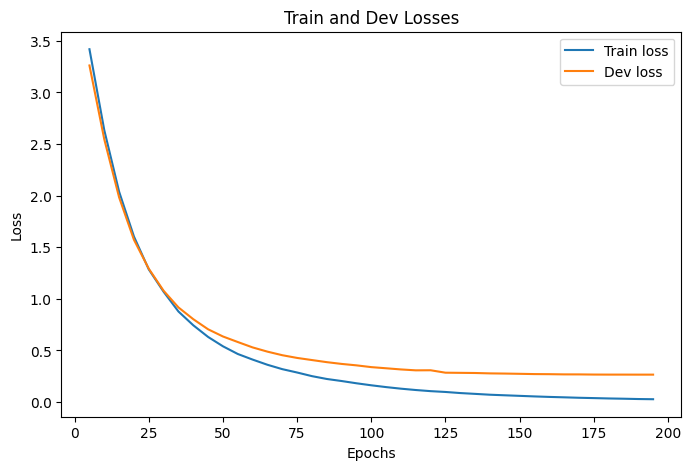

In [25]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Dev Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epochs, losses_train, label='Train loss')
plt.plot(sampled_epochs, losses_dev, label='Dev loss')
plt.legend()
plt.show()

### Multiple runs
To have reliable results on small corpora we have to train and test the model from scratch for several times. At the end, we average the results and we compute the standard deviation.

In [26]:
hid_size = 200
emb_size = 300

lr = 0.0001 # learning rate
clip = 5 # Clip the gradient

out_slot = len(lang.slot2id)
out_int = len(lang.intent2id)
vocab_len = len(lang.word2id)

runs = 5
slot_f1s, intent_acc = [], []
for x in tqdm(range(0, runs)):
    model = ModelIAS(hid_size, out_slot, out_int, emb_size, 
                     vocab_len, pad_index=PAD_TOKEN).to(device)
    model.apply(init_weights)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
    criterion_intents = nn.CrossEntropyLoss()
    
    n_epochs = 200
    patience = 3
    losses_train = []
    losses_dev = []
    sampled_epochs = []
    best_f1 = 0
    for x in range(1,n_epochs):
        loss = train_loop(train_loader, optimizer, criterion_slots, 
                          criterion_intents, model)
        if x % 5 == 0:
            sampled_epochs.append(x)
            losses_train.append(np.asarray(loss).mean())
            results_dev, intent_res, loss_dev = eval_loop(dev_loader, criterion_slots, 
                                                          criterion_intents, model, lang)
            losses_dev.append(np.asarray(loss_dev).mean())
            f1 = results_dev['total']['f']

            if f1 > best_f1:
                best_f1 = f1
            else:
                patience -= 1
            if patience <= 0: # Early stoping with patient
                break # Not nice but it keeps the code clean

    results_test, intent_test, _ = eval_loop(test_loader, criterion_slots, 
                                             criterion_intents, model, lang)
    intent_acc.append(intent_test['accuracy'])
    slot_f1s.append(results_test['total']['f'])
slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)
print('Slot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(slot_f1s.std(), 3))

100%|██████████| 5/5 [21:28<00:00, 257.63s/it]

Slot F1 0.923 +- 0.002
Intent Acc 0.936 +- 0.002


 ![](https://huggingface.co/front/assets/huggingface_logo-noborder.svg)
# Hugging Face
Hugging Face is a library that allows you to used large pretrained models in an easy way. This means that you do not need to implement an architeture and train it from scratch. Hugging Face is also a community where people share trained models and code.
<br/><br/>
In Hugging Face there are many different models (https://huggingface.co/models) that you can import and each of them has its own input and output shapes. However, Transformer-based models are usually composed of two parts: 
- **Tokenizer**
- **Architecture/Pretrained model**

The **tokenizers** used by Transformer-based models are different from those we saw in the lab. While for instance Spacy's tokenizer is rule-based and splits the text looking at the punctuation, the goal of Transformer tokenizers is to reduce the vocabulary length by spliting words into subwords. To do this, several algorithms have been proposed. If you are interested in this topic you can find a thoroughly explanation here: https://huggingface.co/docs/transformers/tokenizer_summary  

In [28]:
# BERT model script from: huggingface.co
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

inputs = tokenizer("I saw a man with a telescope", return_tensors="pt")
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state

C:\Users\adnan\anaconda3\envs\NLU-LABs-venv\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\adnan\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
print(inputs)

{'input_ids': tensor([[  101,  1045,  2387,  1037,  2158,  2007,  1037, 12772,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}


# Exercise (2 points)
Modify the baseline architecture Model IAS in an addition way:
- Add bidirectionality
- Add dropout layer

***Dataset to use: ATIS***

Train samples: 4978
Test samples: 893
Train:
{'abbreviation': 2.9000000000000004,
 'aircraft': 1.6,
 'airfare': 8.5,
 'airline': 3.2,
 'airline+flight_no': 0.0,
 'airport': 0.4,
 'capacity': 0.3,
 'city': 0.4,
 'distance': 0.4,
 'flight': 73.7,
 'flight+airfare': 0.4,
 'flight_no': 0.3,
 'flight_time': 1.0999999999999999,
 'ground_fare': 0.4,
 'ground_service': 5.1,
 'meal': 0.1,
 'quantity': 1.0,
 'restriction': 0.1}
Dev:
{'abbreviation': 3.0,
 'aircraft': 1.7000000000000002,
 'airfare': 8.5,
 'airline': 3.2,
 'airport': 0.3,
 'capacity': 0.3,
 'city': 0.3,
 'distance': 0.3,
 'flight': 73.7,
 'flight+airfare': 0.5,
 'flight_no': 0.2,
 'flight_time': 1.0,
 'ground_fare': 0.3,
 'ground_service': 5.2,
 'meal': 0.2,
 'quantity': 1.0,
 'restriction': 0.2}
Test:
{'abbreviation': 3.6999999999999997,
 'aircraft': 1.0,
 'airfare': 5.4,
 'airfare+flight': 0.1,
 'airline': 4.3,
 'airport': 2.0,
 'capacity': 2.4,
 'city': 0.7000000000000001,
 'day_name': 0.2,
 'distance': 1.0999999999999999,
 'fl

 77%|███████▋  | 154/199 [05:37<01:38,  2.19s/it]


Slot F1:  0.9350372736954207
Intent Accuracy: 0.9540873460246361


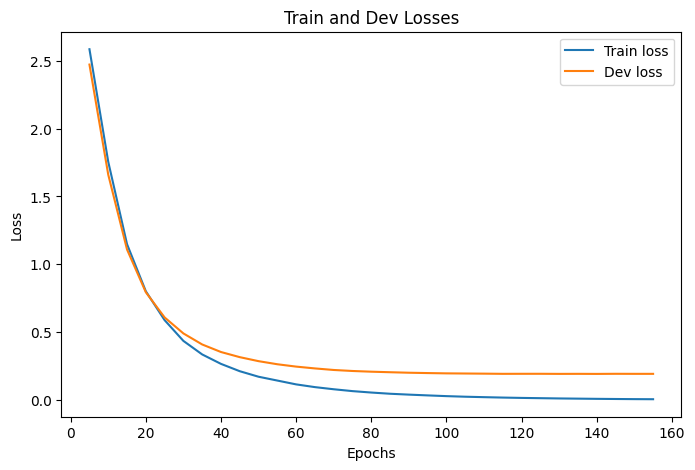

In [36]:
# Importing libraries
import os
import json
from pprint import pprint
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import torch
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from conll import evaluate
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.optim as optim


# Global variables
device = 'cuda:0'  # cuda:0 means we are using the GPU with id 0, if you have multiple GPU
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"  # Used to report errors on CUDA side
PAD_TOKEN = 0


# Lang class to create vocabularies for words, intents and slots and convert them to ids (Vectors)
class Lang:
    def __init__(self, words, intents, slots, cutoff=0):
        self.word2id = self.w2id(words, cutoff=cutoff, unk=True)
        self.slot2id = self.lab2id(slots)
        self.intent2id = self.lab2id(intents, pad=False)
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.id2slot = {v: k for k, v in self.slot2id.items()}
        self.id2intent = {v: k for k, v in self.intent2id.items()}

    def w2id(self, elements, cutoff=None, unk=True):
        vocab = {'pad': PAD_TOKEN}
        if unk:
            vocab['unk'] = len(vocab)
        count = Counter(elements)
        for k, v in count.items():
            if v > cutoff:
                vocab[k] = len(vocab)
        return vocab

    def lab2id(self, elements, pad=True):
        vocab = {}
        if pad:
            vocab['pad'] = PAD_TOKEN
        for elem in elements:
            vocab[elem] = len(vocab)
        return vocab


# Customize the Dataset class to load the data and convert it to ids using the Lang class
class IntentsAndSlots(data.Dataset):
    # Mandatory methods are __init__, __len__ and __getitem__
    def __init__(self, dataset, lang, unk='unk'):
        self.utterances = []
        self.intents = []
        self.slots = []
        self.unk = unk

        for x in dataset:
            self.utterances.append(x['utterance'])
            self.slots.append(x['slots'])
            self.intents.append(x['intent'])

        self.utt_ids = self.mapping_seq(self.utterances, lang.word2id)
        self.slot_ids = self.mapping_seq(self.slots, lang.slot2id)
        self.intent_ids = self.mapping_lab(self.intents, lang.intent2id)

    def __len__(self):
        return len(self.utterances)

    def __getitem__(self, idx):
        utt = torch.Tensor(self.utt_ids[idx])
        slots = torch.Tensor(self.slot_ids[idx])
        intent = self.intent_ids[idx]
        sample = {'utterance': utt, 'slots': slots, 'intent': intent}
        return sample

    # Auxiliary methods
    def mapping_lab(self, data, mapper):
        return [mapper[x] if x in mapper else mapper[self.unk] for x in data]

    def mapping_seq(self, data, mapper):  # Map sequences to number
        res = []
        for seq in data:
            tmp_seq = []
            for x in seq.split():
                if x in mapper:
                    tmp_seq.append(mapper[x])
                else:
                    tmp_seq.append(mapper[self.unk])
            res.append(tmp_seq)
        return res


# Model Class: Defines a neural network in Pytorch
class ModelIAS(nn.Module):
    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, n_layer=1, pad_index=0):
        super(ModelIAS, self).__init__()
        # hid_size = Hidden size
        # out_slot = number of slots (output size for slot filling)
        # out_int = number of intents (ouput size for intent class)
        # emb_size = word embedding size

        self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx=pad_index)

        # LSTM layer with bidirectionality
        self.utt_encoder = nn.LSTM(emb_size, hid_size, n_layer, bidirectional=True)
        # Output Linear layers for slot filling and intent classification
        # hid_size * 2 because of bidirectionality (concatenation of the forward and backward hidden states)
        self.slot_out = nn.Linear(hid_size * 2, out_slot)  # bidirectional = True -> hid_size * 2
        self.intent_out = nn.Linear(hid_size * 2, out_int)  # bidirectional = True -> hid_size * 2

        # Dropout layer
        self.dropout = nn.Dropout(0.1)

    def forward(self, utterance, seq_lengths):
        # utterance.size() = batch_size X seq_len
        utt_emb = self.embedding(utterance)  # utt_emb.size() = batch_size X seq_len X emb_size
        utt_emb = utt_emb.permute(1, 0, 2)  # we need seq len first -> seq_len X batch_size X emb_size

        # pack_padded_sequence avoid computation over pad tokens reducing the computational cost

        packed_input = pack_padded_sequence(utt_emb, seq_lengths.cpu().numpy())
        # Process the batch
        packed_output, (last_hidden, cell) = self.utt_encoder(packed_input)
        # Unpack the sequence
        utt_encoded, input_sizes = pad_packed_sequence(packed_output)

        # Apply dropout to the output of the LSTM layer
        # Since LSTM layer is bidirectional, we need to apply dropout to both directions (forward and backward)
        # For this reason we need to split the tensor in two parts and apply dropout to each part
        #  OR we need to apply dropout to the concatenation of the two parts: forward and backward hidden states
        # Concatenate the final forward (last_hidden[-2,:,:]) and backward (last_hidden[-1,:,:]) hidden layers
        # and apply dropout
        last_hidden = self.dropout(torch.cat((last_hidden[-2, :, :], last_hidden[-1, :, :]), dim=1))
        utt_encoded = self.dropout(utt_encoded)

        # Compute slot logits
        slots = self.slot_out(utt_encoded)
        # Compute intent logits
        intent = self.intent_out(last_hidden)
        # Slot size: seq_len, batch size, calsses
        slots = slots.permute(1, 2, 0)  # We need this for computing the loss
        # Slot size: batch_size, classes, seq_len
        return slots, intent


# Function to load the data from the json file
def load_data(path):
    """
        input: path/to/data
        output: json
    """
    dataset = []
    with open(path) as f:
        dataset = json.loads(f.read())
    return dataset


# Collate_fn function which is passed to the DataLoader class to create batches
def collate_fn(data):
    def merge(sequences):
        '''
        merge from batch * sent_len to batch * max_len
        '''
        lengths = [len(seq) for seq in sequences]
        max_len = 1 if max(lengths) == 0 else max(lengths)
        # Pad token is zero in our case
        # So we create a matrix full of PAD_TOKEN (i.e. 0) with the shape
        # batch_size X maximum length of a sequence
        padded_seqs = torch.LongTensor(len(sequences), max_len).fill_(PAD_TOKEN)

        for i, seq in enumerate(sequences):
            end = lengths[i]
            padded_seqs[i, :end] = seq  # We copy each sequence into the matrix

        # print(padded_seqs)
        padded_seqs = padded_seqs.detach()  # We remove these tensors from the computational graph

        return padded_seqs, lengths

    # Sort data by seq lengths
    data.sort(key=lambda x: len(x['utterance']), reverse=True)

    new_item = {}
    for key in data[0].keys():
        new_item[key] = [d[key] for d in data]

    # We just need one length for packed pad seq, since len(utt) == len(slots)
    src_utt, _ = merge(new_item['utterance'])
    y_slots, y_lengths = merge(new_item["slots"])
    intent = torch.LongTensor(new_item["intent"])

    src_utt = src_utt.to(device)  # We load the Tensor on our selected device
    y_slots = y_slots.to(device)
    intent = intent.to(device)
    y_lengths = torch.LongTensor(y_lengths).to(device)

    new_item["utterances"] = src_utt
    new_item["intents"] = intent
    new_item["y_slots"] = y_slots
    new_item["slots_len"] = y_lengths

    return new_item


# Function to randomly initialize the weights of a neural network in Pytorch based on the type of layer
def init_weights(mat):
    for m in mat.modules():
        if type(m) in [nn.GRU, nn.LSTM, nn.RNN]:
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    for idx in range(4):
                        mul = param.shape[0] // 4
                        torch.nn.init.xavier_uniform_(param[idx * mul:(idx + 1) * mul])
                elif 'weight_hh' in name:
                    for idx in range(4):
                        mul = param.shape[0] // 4
                        torch.nn.init.orthogonal_(param[idx * mul:(idx + 1) * mul])
                elif 'bias' in name:
                    param.data.fill_(0)
        else:
            if type(m) in [nn.Linear]:
                torch.nn.init.uniform_(m.weight, -0.01, 0.01)
                if m.bias != None:
                    m.bias.data.fill_(0.01)


# Train Loop and Evaluation Loop Functions
# We define two functions one for training our model and the other for evaluating it.To compute the performances on the
# slot filling task we will use the ** conll script **, while for the intent classification task we are going to use
# the ** classification_report **.
def train_loop(data, optimizer, criterion_slots, critenrion_intents, model):
    model.train()
    loss_array = []
    for sample in data:
        optimizer.zero_grad()  # Zeroing the gradient
        slots, intent = model(sample['utterances'], sample['slots_len'])
        loss_intent = criterion_intents(intent, sample['intents'])
        loss_slot = criterion_slots(slots, sample['y_slots'])
        loss = loss_intent + loss_slot  # In joint training we sum the losses.
        # Is there another way to do that?
        loss_array.append(loss.item())
        loss.backward()  # Compute the gradient, deleting the computational graph
        # clip the gradient to avoid explosioning gradients
        # torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()  # Update the weights
    return loss_array


def eval_loop(data, criterion_slots, criterion_intents, model, lang):
    model.eval()
    loss_array = []

    ref_intents = []
    hyp_intents = []

    ref_slots = []
    hyp_slots = []
    # softmax = nn.Softmax(dim=1) # Use Softmax if you need the actual probability
    with torch.no_grad():  # It used to avoid the creation of computational graph
        for sample in data:
            slots, intents = model(sample['utterances'], sample['slots_len'])
            loss_intent = criterion_intents(intents, sample['intents'])
            loss_slot = criterion_slots(slots, sample['y_slots'])
            loss = loss_intent + loss_slot
            loss_array.append(loss.item())
            # Intent inference
            # Get the highest probable class
            out_intents = [lang.id2intent[x]
                           for x in torch.argmax(intents, dim=1).tolist()]
            gt_intents = [lang.id2intent[x] for x in sample['intents'].tolist()]
            ref_intents.extend(gt_intents)
            hyp_intents.extend(out_intents)

            # Slot inference
            output_slots = torch.argmax(slots, dim=1)
            for id_seq, seq in enumerate(output_slots):
                length = sample['slots_len'].tolist()[id_seq]
                utt_ids = sample['utterance'][id_seq][:length].tolist()
                gt_ids = sample['y_slots'][id_seq].tolist()
                gt_slots = [lang.id2slot[elem] for elem in gt_ids[:length]]
                utterance = [lang.id2word[elem] for elem in utt_ids]
                to_decode = seq[:length].tolist()
                ref_slots.append([(utterance[id_el], elem) for id_el, elem in enumerate(gt_slots)])
                tmp_seq = []
                for id_el, elem in enumerate(to_decode):
                    tmp_seq.append((utterance[id_el], lang.id2slot[elem]))
                hyp_slots.append(tmp_seq)
    try:
        results = evaluate(ref_slots, hyp_slots)
    except Exception as ex:
        # Sometimes the model predics a class that is not in REF
        print(ex)
        ref_s = set([x[1] for x in ref_slots])
        hyp_s = set([x[1] for x in hyp_slots])
        print(hyp_s.difference(ref_s))

    report_intent = classification_report(ref_intents, hyp_intents,
                                          zero_division=False, output_dict=True)
    return results, report_intent, loss_array


# 1. Load data, split into train and test set
tmp_train_raw = load_data(os.path.join('dataset', 'ATIS', 'train.json'))
test_raw = load_data(os.path.join('dataset', 'ATIS', 'test.json'))
print('Train samples:', len(tmp_train_raw))
print('Test samples:', len(test_raw))

# 2. Create a dev set
# First we get the 10% of dataset, then compute the percentage of these examples on the training set which is around 11%
portion = round(((len(tmp_train_raw) + len(test_raw)) * 0.10) / (len(tmp_train_raw)), 2)
intents = [x['intent'] for x in tmp_train_raw]  # We stratify on intents
count_y = Counter(intents)

# 3. Split the training set into train and dev set with stratification (same distribution of intents)
Y = []
X = []
mini_Train = []
for id_y, y in enumerate(intents):
    if count_y[y] > 1:  # If some intents occur once only, we put them in training
        X.append(tmp_train_raw[id_y])
        Y.append(y)
    else:
        mini_Train.append(tmp_train_raw[id_y])
# Random Stratify
X_train, X_dev, y_train, y_dev = train_test_split(X, Y, test_size=portion,
                                                  random_state=42,
                                                  shuffle=True,
                                                  stratify=Y)
X_train.extend(mini_Train)
train_raw = X_train
dev_raw = X_dev

y_test = [x['intent'] for x in test_raw]

# Intent distribution
print('Train:')
pprint({k: round(v / len(y_train), 3) * 100 for k, v in sorted(Counter(y_train).items())})
print('Dev:'),
pprint({k: round(v / len(y_dev), 3) * 100 for k, v in sorted(Counter(y_dev).items())})
print('Test:')
pprint({k: round(v / len(y_test), 3) * 100 for k, v in sorted(Counter(y_test).items())})
print('=' * 89)
# Dataset size
print('TRAIN size:', len(train_raw))
print('DEV size:', len(dev_raw))
print('TEST size:', len(test_raw))

# 4. Convert words to numbers (word2id)
words = sum([x['utterance'].split() for x in train_raw], [])  # No set() since we want to compute the cutoff
corpus = train_raw + dev_raw + test_raw  # We do not want unk labels, # however this depends on the research purpose
slots = set(sum([line['slots'].split() for line in corpus], []))
intents = set([line['intent'] for line in corpus])

# 5. Create the lang object that will be used to convert words to numbers
lang = Lang(words, intents, slots, cutoff=0)


# 6. Create the datasets and dataloaders for train, dev and test set
train_dataset = IntentsAndSlots(train_raw, lang)
dev_dataset = IntentsAndSlots(dev_raw, lang)
test_dataset = IntentsAndSlots(test_raw, lang)

# Dataloader instantiation
train_loader = DataLoader(train_dataset, batch_size=128, collate_fn=collate_fn, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=64, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn)

# 7. Training set up
hid_size = 200
emb_size = 300

lr = 0.0001  # learning rate
clip = 5  # Clip the gradient

out_slot = len(lang.slot2id)
out_int = len(lang.intent2id)
vocab_len = len(lang.word2id)

model = ModelIAS(hid_size, out_slot, out_int, emb_size, vocab_len, pad_index=PAD_TOKEN).to(device)
model.apply(init_weights)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
criterion_intents = nn.CrossEntropyLoss()  # Because we do not have the pad token

# 8. Train a neural network model for intent detection and slot filling (with early stopping)
n_epochs = 200
patience = 3  # Early stopping patience
losses_train = []
losses_dev = []
sampled_epochs = []
best_f1 = 0

for x in tqdm(range(1, n_epochs)):
    loss = train_loop(train_loader, optimizer, criterion_slots, criterion_intents, model)
    if x % 5 == 0:
        sampled_epochs.append(x)
        losses_train.append(np.asarray(loss).mean())
        results_dev, intent_res, loss_dev = eval_loop(dev_loader, criterion_slots, criterion_intents, model, lang)
        losses_dev.append(np.asarray(loss_dev).mean())
        f1 = results_dev['total']['f']

        if f1 > best_f1:
            best_f1 = f1
            patience = 3
        else:
            patience -= 1
        if patience <= 0:  # Early stopping with patience
            break  # Not nice but it keeps the code clean


# 9. Evaluate the model on the test set
results_test, intent_test, _ = eval_loop(test_loader, criterion_slots, criterion_intents, model, lang)
print('Slot F1: ', results_test['total']['f'])
print('Intent Accuracy:', intent_test['accuracy'])

# 10. Plot of the train and valid losses during training (one plot for the train and one for the dev)
plt.figure(num=3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Dev Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epochs, losses_train, label='Train loss')
plt.plot(sampled_epochs, losses_dev, label='Dev loss')
plt.legend()
plt.show()

# Exercise (4 points)
Train a BERT model using a multi-task learning setting on intent classification and slot filling. 
<br>
You can refer to this paper to have a better understanding of such model: https://arxiv.org/abs/1902.10909

***Dataset to use: ATIS***


In [170]:
# Importing libraries
import copy
import json
import os
from collections import Counter
from pprint import pprint

import numpy as np
import torch
import torch.nn as nn
from seqeval.metrics import f1_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset
from tqdm import tqdm, trange
from transformers import AdamW
from transformers import BertPreTrainedModel, BertModel, BertConfig
from transformers import BertTokenizer
from transformers import get_linear_schedule_with_warmup

# Global variables
device = 'cuda:0'  # cuda:0 means we are using the GPU with id 0, if you have multiple GPU
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"  # Used to report errors on CUDA side

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


class InputSample:
    def __init__(self, id_, words_, intent_, slot_labels_):
        self.id = id_
        self.words = words_
        self.intent = intent_
        self.slot_labels = slot_labels_

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"


class InputFeatures:
    def __init__(self, input_id, attention_mask, token_type_id, intent_label_id, slot_labels_ids):
        self.input_id = input_id
        self.attention_mask = attention_mask
        self.token_type_id = token_type_id
        self.intent_label_id = intent_label_id
        self.slot_labels_ids = slot_labels_ids

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"


class DataProcessor:
    def __init__(self, train_raw_, dev_raw_, test_raw_, intent_labels_, slot_labels_):
        self.train_raw = train_raw_
        self.dev_raw = dev_raw_
        self.test_raw = test_raw_

        self.intent_labels = intent_labels_
        self.slot_labels = slot_labels_

    def create_birt_format(self, mode):
        data_ = []

        if mode == "train":
            raw = self.train_raw
        elif mode == "dev":
            raw = self.dev_raw
        elif mode == "test":
            raw = self.test_raw
        else:
            raise ValueError("The mode should be in train, dev or test")

        for i_, input_dict in enumerate(raw):
            input_id = "%s-%d" % (mode, i_)

            words_ = input_dict['utterance'].split()
            intent_ = input_dict['intent']
            intent_label_ = self.intent_labels.index(intent_) if intent_ in self.intent_labels else self.intent_labels.index('UNK')
            slots_ = input_dict['slots'].split()
            slot_labels = [self.slot_labels.index(s) if s in self.slot_labels else self.slot_labels.index('UNK') for s in slots_]

            assert len(words_) == len(slot_labels)  # Sanity check

            data_.append(InputSample(id_=input_id, words_=words_, intent_=intent_label_, slot_labels_=slot_labels))

        return data_


class BertForIntentClassificationAndSlotFilling(BertPreTrainedModel):
    def __init__(self, config, intent_label_lst, slot_label_lst, dropout_rate=0.1, ignore_index=0, slot_loss_coef=1.0):
        super(BertForIntentClassificationAndSlotFilling, self).__init__(config)
        self.num_intent_labels = len(intent_label_lst)
        self.num_slot_labels = len(slot_label_lst)
        self.ignore_index = ignore_index
        self.slot_loss_coef = slot_loss_coef


        self.bert = BertModel(config)
        self.dropout = nn.Dropout(dropout_rate)
        self.intent_classifier = nn.Linear(config.hidden_size, self.num_intent_labels)
        self.slot_classifier = nn.Linear(config.hidden_size, self.num_slot_labels)

        # self.init_weights()

    def forward(self, input_ids, attention_mask, token_type_ids, intent_label_ids, slot_label_ids):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs[0]
        pooled_output = outputs[1]
        # pooled_output = self.dropout(sequence_output[:, 0, :])

        intent_logits = self.intent_classifier(pooled_output)
        slot_logits = self.slot_classifier(sequence_output)

        total_loss = 0

        if intent_label_ids is not None and slot_label_ids is not None:
            # Intent Classification Loss
            intent_loss_fct = nn.CrossEntropyLoss()
            intent_loss = intent_loss_fct(intent_logits.view(-1, self.num_intent_labels), intent_label_ids.view(-1))
            total_loss += intent_loss

            # Slot Filling Loss
            slot_loss_fct = nn.CrossEntropyLoss(ignore_index=pad_token_label_id)
            if attention_mask is not None:
                slot_active_loss = attention_mask.view(-1) == 1
                slot_active_logits = slot_logits.view(-1, self.num_slot_labels)[slot_active_loss]
                slot_active_labels = slot_label_ids.view(-1)[slot_active_loss]
                slot_loss = slot_loss_fct(slot_active_logits, slot_active_labels)
            else:
                slot_loss = slot_loss_fct(slot_logits.view(-1, self.num_slot_labels), slot_label_ids.view(-1))

            total_loss += slot_loss * self.slot_loss_coef

        outputs = ((intent_logits, slot_logits),) + outputs[2:]
        outputs = (total_loss,) + outputs

        return outputs


# Function to load the data from the json file
def load_data(path):
    """
        input: path/to/data
        output: json
    """
    with open(path) as f:
        dataset = json.loads(f.read())

    return dataset


def input2features(input_sample, max_seq_len, tokenizer, pad_token_label_id=100, cls_token_segment_id=0,
                   pad_token_segment_id=0, sequence_a_segment_id=0, mask_padding_with_zero=True):
    cls_token = tokenizer.cls_token
    sep_token = tokenizer.sep_token
    unk_token = tokenizer.unk_token
    pad_token_id = tokenizer.pad_token_id

    features = []

    for i, sample in enumerate(input_sample):
        tokens = []
        slot_labels_ids = []

        for word, slot_label in zip(sample.words, sample.slot_labels):
            word_tokens = tokenizer.tokenize(word)

            # handle bad encoded word
            if len(word_tokens) == 0:
                word_tokens = [unk_token]

            tokens.extend(word_tokens)

            # Use the real label id for the first token of the word, and padding ids for the remaining tokens
            slot_labels_ids.extend([int(slot_label)] + [pad_token_label_id] * (len(word_tokens) - 1))

        # Account for [CLS] and [SEP] with "- 2" and with "- 3" for RoBERTa.
        special_tokens_count = tokenizer.num_special_tokens_to_add()
        # special_tokens_count = 2
        if len(tokens) > max_seq_len - special_tokens_count:
            tokens = tokens[: (max_seq_len - special_tokens_count)]
            slot_labels_ids = slot_labels_ids[: (max_seq_len - special_tokens_count)]

        # Add [SEP] token
        tokens += [sep_token]
        slot_labels_ids += [pad_token_label_id]
        token_type_ids = [sequence_a_segment_id] * len(tokens)

        # Add [CLS] token
        tokens = [cls_token] + tokens
        slot_labels_ids += [pad_token_label_id]
        token_type_ids = [cls_token_segment_id] + token_type_ids

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real tokens are attended to.
        attention_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # 0 padding up to the sequence length.
        padding_length = max_seq_len - len(input_ids)
        input_ids += ([pad_token_id] * padding_length)
        attention_mask += ([0 if mask_padding_with_zero else 1] * padding_length)
        slot_labels_ids += ([pad_token_label_id] * padding_length)
        token_type_ids += ([pad_token_segment_id] * padding_length)

        assert len(input_ids) == max_seq_len, "Error with input length {} vs {}".format(len(input_ids), max_seq_len)
        assert len(attention_mask) == max_seq_len, "Error with input length {} vs {}".format(len(attention_mask), max_seq_len)
        assert len(token_type_ids) == max_seq_len, "Error with input length {} vs {}".format(len(token_type_ids), max_seq_len)
        assert len(slot_labels_ids) == max_seq_len, "Error with input length {} vs {}".format(len(slot_labels_ids), max_seq_len)

        intent_label_id = int(sample.intent)

        features.append(
            InputFeatures(
                input_id=input_ids,
                attention_mask=attention_mask,
                token_type_id=token_type_ids,
                slot_labels_ids=slot_labels_ids,
                intent_label_id=intent_label_id
            )
        )

    return features


def convert_to_tensor(features):
    all_input_ids = torch.tensor([f.input_id for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_id for f in features], dtype=torch.long)
    all_slot_labels_ids = torch.tensor([f.slot_labels_ids for f in features], dtype=torch.long)
    all_intent_label_ids = torch.tensor([f.intent_label_id for f in features], dtype=torch.long)

    dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_slot_labels_ids, all_intent_label_ids)

    return dataset


def train(model, train_dataset, optimizer, n_epochs, gradient_accumulation_steps, warmup_steps, max_grad_norm, device):
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=train_batch_size)

    t_total = len(train_dataloader) // gradient_accumulation_steps * n_epochs

    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)

    global_step = 0
    tr_loss = 0.0
    model.zero_grad()

    train_iterator = trange(int(n_epochs), desc="Epoch")

    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration")
        for step, batch in enumerate(epoch_iterator):
            model.train()
            batch = tuple(b.to(device) for b in batch)

            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2],
                      'intent_label_ids': batch[4],
                      'slot_label_ids': batch[3]}

            outputs = model(**inputs)
            loss = outputs[0]

            if gradient_accumulation_steps > 1:
                loss = loss / gradient_accumulation_steps

            loss.backward()

            tr_loss += loss.item()
            if (step + 1) % gradient_accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

                optimizer.step()
                scheduler.step()
                model.zero_grad()
                global_step += 1

    return global_step, tr_loss / global_step


# evaluation method
def evaluate_test(model, dataset, slot_label_lst, batch_size, device, pad_token_label_id):
    data_sampler = SequentialSampler(dataset)
    dataloader = DataLoader(dataset, sampler=data_sampler, batch_size=batch_size)

    loss = 0.0
    nb_steps = 0
    intent_preds = None
    slot_preds = None
    out_intent_label_ids = None
    out_slot_labels_ids = None

    model.eval()

    for batch in tqdm(dataloader, desc="Evaluating"):
        batch = tuple(b.to(device) for b in batch)

        with torch.no_grad():
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2],
                      'intent_label_ids': batch[4],
                      'slot_label_ids': batch[3]}

            outputs = model(**inputs)
            temp_loss, (intent_logits, slot_logits) = outputs[:2]

            loss += temp_loss.mean().item()

        nb_steps += 1

        # intent prediction
        if intent_preds is None:
            intent_preds = intent_logits.detach().cpu().numpy()
            out_intent_label_ids = inputs['intent_label_ids'].detach().cpu().numpy()
        else:
            intent_preds = np.append(intent_preds, intent_logits.detach().cpu().numpy(), axis=0)
            out_intent_label_ids = np.append(out_intent_label_ids, inputs['intent_label_ids'].detach().cpu().numpy(), axis=0)

        # slot prediction/
        if slot_preds is None:
            slot_preds = slot_logits.detach().cpu().numpy()
            out_slot_labels_ids = inputs["slot_label_ids"].detach().cpu().numpy()
        else:
            slot_preds = np.append(slot_preds, slot_logits.detach().cpu().numpy(), axis=0)
            out_slot_labels_ids = np.append(out_slot_labels_ids, inputs["slot_label_ids"].detach().cpu().numpy(), axis=0)

    eval_loss = loss / nb_steps
    results = {
        "loss": eval_loss
    }

    # Intent result
    intent_preds = np.argmax(intent_preds, axis=1)
    out_intent_label_ids = out_intent_label_ids.reshape(-1)
    intent_result = (intent_preds == out_intent_label_ids).mean()

    # Slot result
    slot_preds = np.argmax(slot_preds, axis=2)

    # Remove ignored index (special tokens)
    slot_preds_list = [[] for _ in range(slot_preds.shape[0])]
    slot_label_list = [[] for _ in range(slot_preds.shape[0])]

    for i in range(slot_preds.shape[0]):
        for j in range(slot_preds.shape[1]):
            if out_slot_labels_ids[i, j] != pad_token_label_id:
                slot_preds_list[i].append(slot_label_lst[slot_preds[i][j]])
                slot_label_list[i].append(slot_label_lst[out_slot_labels_ids[i][j]])

    slot_result = f1_score(slot_label_list, slot_preds_list)

    results["intent_result"] = intent_result
    results["slot_result"] = slot_result

    return results


# 1. Load data
tmp_train_raw = load_data(os.path.join('dataset', 'ATIS', 'train.json'))
test_raw = load_data(os.path.join('dataset', 'ATIS', 'test.json'))
print('Train samples:', len(tmp_train_raw))
print('Test samples:', len(test_raw))

# 2. Create a train, test and dev set
portion = round(((len(tmp_train_raw) + len(test_raw)) * 0.10) / (len(tmp_train_raw)), 2)
intents = [x['intent'] for x in tmp_train_raw]  # We stratify on intents
count_y = Counter(intents)

Y = []
X = []
mini_Train = []
for id_y, y in enumerate(intents):
    if count_y[y] > 1:  # If some intents occur once only, we put them in training
        X.append(tmp_train_raw[id_y])
        Y.append(y)
    else:
        mini_Train.append(tmp_train_raw[id_y])

# Random Stratify
X_train, X_dev, y_train, y_dev = train_test_split(X, Y, test_size=portion, random_state=42, shuffle=True, stratify=Y)
X_train.extend(mini_Train)
train_raw = X_train
dev_raw = X_dev

y_test = [x['intent'] for x in test_raw]
# Intent distribution
print('Train:')
pprint({k: round(v / len(y_train), 3) * 100 for k, v in sorted(Counter(y_train).items())})
print('Dev:'),
pprint({k: round(v / len(y_dev), 3) * 100 for k, v in sorted(Counter(y_dev).items())})
print('Test:')
pprint({k: round(v / len(y_test), 3) * 100 for k, v in sorted(Counter(y_test).items())})
print('=' * 89)
# Dataset size
print('TRAIN size:', len(train_raw))
print('DEV size:', len(dev_raw))
print('TEST size:', len(test_raw))

# 3. Prepare data for BERT model
words = sum([x['utterance'].split() for x in train_raw], [])  # No set() since we want to compute the cutoff
corpus = train_raw + dev_raw + test_raw  # We do not want unk labels, # however this depends on the research purpose
slots_ = set(sum([line['slots'].split() for line in corpus], []))
intents_ = set([line['intent'] for line in corpus])

slots = list(slots_)
intents = list(intents_)
intents.append("UNK")
slots.append("UNK")

# 4. Create a data processor that will create the BERT input data
data_processor = DataProcessor(X_train, X_dev, test_raw, intents, slots)
train_data = data_processor.create_birt_format("train")
dev_data = data_processor.create_birt_format("dev")
test_data = data_processor.create_birt_format("test")

pad_token_label_id = 0  # ignore index 0: "O" token
max_seq_len = 50

# 5. Convert data to features
train_features = input2features(train_data, max_seq_len, tokenizer, pad_token_label_id=pad_token_label_id)
test_features = input2features(test_data, max_seq_len, tokenizer, pad_token_label_id=pad_token_label_id)
dev_features = input2features(dev_data, max_seq_len, tokenizer, pad_token_label_id=pad_token_label_id)

# 6. Convert features to tensors
train_dataset = convert_to_tensor(train_features)
test_dataset = convert_to_tensor(test_features)
dev_dataset = convert_to_tensor(dev_features)

# 7. Initiate Model
config = BertConfig.from_pretrained('bert-base-uncased', finetuning_task='intent-classification-and-slot-filling')
model = BertForIntentClassificationAndSlotFilling.from_pretrained('bert-base-uncased', config=config,
                                                                  intent_label_lst=intents, slot_label_lst=slots)
model.to(device)

# 8. Hyperparameters for training
train_batch_size = 32
eval_batch_size = 32
n_epochs = 5.0
gradient_accumulation_steps = 3
lr = 5e-5
adam_epsilon = 1e-8
warmup_steps = 0
max_grad_norm = 1.0


no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if
                not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if
                any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=lr, eps=adam_epsilon)


# 9. Train and evaluate
_, tr_loss = train(model, train_dataset, optimizer, n_epochs, gradient_accumulation_steps, warmup_steps, max_grad_norm,
                   device)

print("Train loss: {}".format(tr_loss))

results = evaluate_test(model, test_dataset, slots, eval_batch_size, device, pad_token_label_id)
print("Intent Accuracy: {}".format(results["intent_result"]))
print("Slot F1-Score: {}".format(results["slot_result"]))


Train samples: 4978
Test samples: 893
Train:
{'abbreviation': 2.9000000000000004,
 'aircraft': 1.6,
 'airfare': 8.5,
 'airline': 3.2,
 'airline+flight_no': 0.0,
 'airport': 0.4,
 'capacity': 0.3,
 'city': 0.4,
 'distance': 0.4,
 'flight': 73.7,
 'flight+airfare': 0.4,
 'flight_no': 0.3,
 'flight_time': 1.0999999999999999,
 'ground_fare': 0.4,
 'ground_service': 5.1,
 'meal': 0.1,
 'quantity': 1.0,
 'restriction': 0.1}
Dev:
{'abbreviation': 3.0,
 'aircraft': 1.7000000000000002,
 'airfare': 8.5,
 'airline': 3.2,
 'airport': 0.3,
 'capacity': 0.3,
 'city': 0.3,
 'distance': 0.3,
 'flight': 73.7,
 'flight+airfare': 0.5,
 'flight_no': 0.2,
 'flight_time': 1.0,
 'ground_fare': 0.3,
 'ground_service': 5.2,
 'meal': 0.2,
 'quantity': 1.0,
 'restriction': 0.2}
Test:
{'abbreviation': 3.6999999999999997,
 'aircraft': 1.0,
 'airfare': 5.4,
 'airfare+flight': 0.1,
 'airline': 4.3,
 'airport': 2.0,
 'capacity': 2.4,
 'city': 0.7000000000000001,
 'day_name': 0.2,
 'distance': 1.0999999999999999,
 'fl

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForIntentClassificationAndSlotFilling: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForIntentClassificationAndSlotFilling from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForIntentClassificationAndSlotFilling from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForIntentClassificationAndSlotFilling were not initialized from the model

Train loss: 1.0710827744338247


Evaluating: 100%|██████████| 28/28 [00:03<00:00,  7.40it/s]


Intent Accuracy: 0.9339305711086227
Slot F1-Score: 0.8751094762655456
